<a href="https://colab.research.google.com/github/pedrosena138/assin2-bertimbau-benchmark/blob/main/ASSIN2_Portuguese_BERT_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Install dependencies

In [ ]:
# Install libs
!pip install datasets transformers evaluate huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Huggingface Login

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Git config for upload model

In [ ]:
# Config git
!apt install git-lfs
!git config --global user.email "pmfsl@cin.ufpe.br"
!git config --global user.name "Pedro Sena"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


Checking if transformers lib version is gratter then 4.16.0

In [ ]:
import transformers

assert transformers.__version__ > '4.16.0'
print(transformers.__version__)

4.26.1


In [ ]:
import json
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback
from datasets import load_dataset
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, create_optimizer, pipeline
import evaluate

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [ ]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)

Num GPUs Available:  1


In [ ]:
# Plot style
mpl.rcParams['figure.figsize'] = (14, 12)
plt.style.use('seaborn')

# ASSIN2 Dataset

In [ ]:
dataset = load_dataset('assin2')

Generating train split:   0%|          | 0/6500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2448 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset assin2 downloaded and prepared to /root/.cache/huggingface/datasets/assin2/default/1.0.0/8467f7acbda82f62ab960ca869dc1e96350e0e103a1ef7eaa43bbee530b80061. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset['train'][0]

{'sentence_pair_id': 1,
 'premise': 'Uma criança risonha está segurando uma pistola de água e sendo espirrada com água',
 'hypothesis': 'Uma criança está segurando uma pistola de água',
 'relatedness_score': 4.5,
 'entailment_judgment': 1}

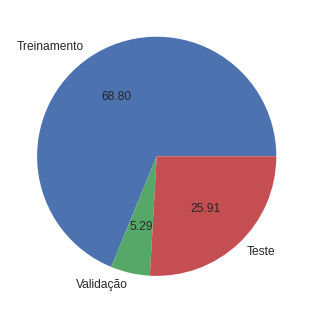

In [ ]:
train_size = dataset['train'].num_rows
val_size = dataset['validation'].num_rows
test_size = dataset['test'].num_rows

plt.pie([train_size, val_size, test_size], labels=['Treinamento', 'Validação', 'Teste'], autopct='%.2f', textprops={'size': 'large'})
plt.show()

In [ ]:
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

final_df = pd.concat([train_df, val_df, test_df])

In [ ]:
final_df.sort_values(by='relatedness_score')

,sentence_pair_id,premise,hypothesis,relatedness_score,entailment_judgment
4294,4295,Um homem irritado está mirando um chimpanzé da...,A mulher está despejando óleo em uma sautese,1.0,0
4301,4302,A banda está cantando,Uma mulher está cuidadosamente removendo sua m...,1.0,0
743,743,Um homem de roupa indiana e henna em sua mão e...,Uma mulher está vestindo uma camisa colorida e...,1.0,0
6154,6155,Uma mulher está mergulhando um camarão na massa,Um homem está dirigindo um carro,1.0,0
1478,1478,O homem de azul está posando para uma foto ao ...,Uma mulher está parada ao volante de um carro ...,1.0,0
...,...,...,...,...,...
2909,2910,O filhote de cachorro está brincando com um re...,O filhote de cachorro está brincando com um re...,5.0,1
1868,1868,O cavalo está sendo montado por um homem,Um homem está andando a cavalo,5.0,1
2912,2913,Uma mulher está passando sombra,A sombra está sendo passada por uma mulher,5.0,1
2302,2303,Uma mulher está fatiando tofu,Tofu está sendo fatiado por uma mulher,5.0,1


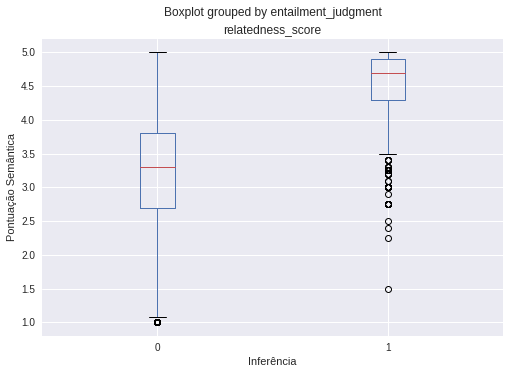

In [ ]:
# scaler = MinMaxScaler()
# norm_df = final_df.copy()

# norm_df['relatedness_score'] = scaler.fit_transform(norm_df['relatedness_score'].values.reshape(-1, 1))

# box_q1 = norm_df['relatedness_score'].quantile(0.25)
# box_q3 = norm_df['relatedness_score'].quantile(0.75)
# box_iqr = box_q3 - box_q1

# lower_whisker = box_q1-1.5*box_iqr
upper_whisker = box_q3+1.5*box_iqr

# norm_df = norm_df.query("`relatedness_score` < @upper_whisker and `relatedness_score` > @lower_whisker")  # [norm_df['relatedness_score'] < upper_whisker & norm_df['relatedness_score'] > lower_whisker]

# norm_df = norm_df[norm_df['relatedness_score'] < upper_whisker]
# norm_df = norm_df[norm_df['relatedness_score'] > lower_whisker]

final_df.boxplot(column='relatedness_score', by='entailment_judgment')

plt.xlabel('Inferência')
plt.ylabel('Pontuação Semântica')
plt.show()

# Pre-processamento

In [ ]:
def get_relatedness_scores():
    scores = []
    for key in dataset.keys():
        scores.extend(dataset[key]['relatedness_score'])
    return np.array(scores)

def encoder(examples):
    return tokenizer(
        examples['premise'],
        examples['hypothesis'],
        truncation=True)
    
def normalize_relatedness_score(examples):
    scores = np.array(examples['relatedness_score'])
    return {'label': scaler.transform(scores.reshape(-1, 1)).reshape(1, -1)[0]}

In [ ]:
def pre_processing(task):
    encoded_dataset = dataset.map(encoder, batched=True)

    if task == 'stsb':
        # Normalize relatedness scores
        # scaler = MinMaxScaler()
        # scores = get_related_scores()
        # scaler.fit(scores.reshape(-1, 1))
        # encoded_dataset = encoded_dataset.map(normalize_relatedness_score, batched=True)
        encoded_dataset = encoded_dataset.map(lambda x: {'label': x['relatedness_score']}, batched=True)
    else:
        encoded_dataset = encoded_dataset.map(lambda x: {'label': x['entailment_judgment']}, batched=True)

    pre_encoder_columns = set(dataset["train"].features)
    encoder_columns = list(set(encoded_dataset["train"].features) - pre_encoder_columns)
    
    return encoded_dataset

# Fine-tuning

In [ ]:
class Metric:
    def __init__(self, task):
        self.task = task
        if self.task == 'stsb':
            self.metric = evaluate.load('pearsonr')
        else:
            self.metric = evaluate.combine(['accuracy', 'f1'])
    
    def compute(self, eval_predictions):
        predictions, labels = eval_predictions
        if self.task == "stsb":
            predictions = predictions[:, 0]
        else:
            predictions = np.argmax(predictions, axis=1)

        return self.metric.compute(predictions=predictions, references=labels)

In [ ]:
def load_model(model_checkpoint, total_train_steps, task):
    from_pt = True if model_checkpoint == "neuralmind/bert-large-portuguese-cased" else False
    optimizer, schedule = create_optimizer(
        init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
    )

    if task == 'stsb':
        model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=1, from_pt=from_pt)
        model.compile(
            optimizer=optimizer,
            loss='mse'
        )
    else:
        id2label = {0: "None", 1: "Entails"}
        label2id = {"None": 0, "Entails": 1}
        
        model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint,
                                          num_labels=2,
                                          id2label=id2label, 
                                          label2id=label2id,
                                          from_pt=from_pt)   
        model.compile(
                optimizer=optimizer,
        )
            
    return model

In [ ]:
def load_tf_dataset(dataset, model, data_collator):
    tf_dataset = model.prepare_tf_dataset(
        dataset,
        shuffle=True,
        batch_size=BATCH_SIZE,
        collate_fn=data_collator,
    )

    return tf_dataset

In [ ]:
def load_callbacks(model_id, task):
    metric = Metric(task)
    metric_callback = KerasMetricCallback(
        metric_fn=metric.compute, eval_dataset=tf_validation_set
    )

    output_path = './drive/MyDrive/models'
    push_to_hub_model_id = f"{model_id}-{task}"

    tensorboard_callback = TensorBoard(log_dir=f"./{push_to_hub_model_id}/logs")

    push_to_hub_callback = PushToHubCallback(
        output_dir=f"./{push_to_hub_model_id}",
        tokenizer=tokenizer,
        hub_model_id=push_to_hub_model_id,
    )

    # checkpoint_callback = ModelCheckpoint(
    #     # Path where to save the model
    #     # The two parameters below mean that we will overwrite
    #     # the current checkpoint if and only if
    #     # the `val_loss` score has improved.
    #     # The saved model name will include the current epoch.
    #     filepath=f"{output_path}/train/{push_to_hub_model_id}/epochs/" + "epoch_{epoch}",
    #     verbose=1,
    # )

    callbacks = [metric_callback, tensorboard_callback, push_to_hub_callback]
    
    return callbacks

In [ ]:
MODELS = [
    {
        "id": "pt-bert-base-finetuned",
        "checkpoint": "neuralmind/bert-base-portuguese-cased"
    },
    {
        "id": "pt-bert-large-finetuned",
        "checkpoint": "neuralmind/bert-large-portuguese-cased"
    },
    {
        "id": "multi-bert-base-finetuned",
        "checkpoint": "bert-base-multilingual-cased"
    },
    {
        "id": "xlm-roberta-base-finetuned",
        "checkpoint": "xlm-roberta-base"
    },
    {
        "id": "xlm-roberta-large-finetuned",
        "checkpoint": "xlm-roberta-large"
    }
]

TASKS = [
    'stsb',
    'rte',
]

BATCH_SIZE = 16
NUM_EPOCHS = 2

for task in TASKS:
    for m in MODELS:
        tokenizer = AutoTokenizer.from_pretrained(m['checkpoint'], model_max_length=train_size)
        encoded_dataset = pre_processing(task)

        batches_per_epoch = train_size // BATCH_SIZE
        total_train_steps = int(batches_per_epoch * NUM_EPOCHS)
        
        model = load_model(m['checkpoint'], total_train_steps, task)

        data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

        tf_train_set = load_tf_dataset(encoded_dataset['train'], model, data_collator)
        tf_validation_set = load_tf_dataset(encoded_dataset['train'], model, data_collator)

        callbacks = load_callbacks(m['id'], task)
        
        print('\n{}-{}'.format(m['id'], task))
        
        history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=NUM_EPOCHS, callbacks=callbacks)
        
        m['history'] = history.history
        m['finetuned'] = model

        filepath = './drive/MyDrive/models/{}-{}-history.json'.format(m['id'], task)
        with open(filepath, 'w') as f:
            json.dump(history.history, f)
    break

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/content/pt-bert-base-finet


pt-bert-base-finetuned-rte
  6/406 [..............................] - ETA: 1:09 - loss: 0.7040

406/406 [==============================] - 173s 387ms/step - loss: 0.3690 - val_loss: 0.2059 - accuracy: 0.9250 - f1: 0.9254


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Cloning https://huggingface.co/pmfsl/pt-bert-large-finetuned-rte into local 


pt-bert-large-finetuned-rte
406/406 [==============================] - 418s 946ms/step - loss: 0.3300 - val_loss: 0.1597 - accuracy: 0.9432 - f1: 0.9439


  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Cloning https://huggingface.co/pmfsl/multi-bert-base-finetuned-rte into local empty directory.


multi-bert-base-finetuned-rte
  6/406 [..............................] - ETA: 1:24 - loss: 0.6319

406/406 [==============================] - 193s 433ms/step - loss: 0.4024 - val_loss: 0.2674 - accuracy: 0.9009 - f1: 0.9013


  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

Some layers of TFXLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Cloning https://huggingface.co/pmfsl/xlm-roberta-base-finetuned-rte into local empty dir


xlm-roberta-base-finetuned-rte
  6/406 [..............................] - ETA: 1:46 - loss: 0.6973

406/406 [==============================] - ETA: 0s - loss: 0.4909

Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


406/406 [==============================] - 216s 480ms/step - loss: 0.4909 - val_loss: 0.3078 - accuracy: 0.8741 - f1: 0.8750


  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

ResourceExhaustedError: ignored

In [ ]:
def plot_loss(history, label='Loss'):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'], label='Val ' + label)
  
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss', fontsize=16)
  plt.legend()

def plot_metrics(history, metrics):
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric])
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend();

def plot_confusion_matrix(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives:', cm[0][0])
  print('False Positives:', cm[0][1])
  print('False Negatives:', cm[1][0])
  print('True Positives:', cm[1][1])

In [ ]:
plot_loss(history)

In [ ]:
del history.history['loss']
del history.history['val_loss']

plot_metrics(history, metrics=history.history.keys())

In [ ]:
results = model.evaluate(tf_test_set, callbacks=callbacks)

In [ ]:
results

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("pmfsl/bert-base-portuguese-cased-finetuned-rte-assin2")
tokenizer = AutoTokenizer.from_pretrained("pmfsl/bert-base-portuguese-cased-finetuned-rte-assin2")
classifier = pipeline("text-classification", "pmfsl/bert-base-portuguese-cased-finetuned-rte-assin2", framework="tf")

In [ ]:
sentences = []
for d in dataset['test']:
    text = '{}. {}'.format(d['premise'], d['hypothesis'])
    sentences.append(text)

In [ ]:
outputs = classifier(sentences)

In [ ]:
label_col = 'relatedness_score' if TASK == 'stsb' else 'entailment_judgment'
label2id = {"None": 0, "Entails": 1}
y = dataset['test'][label_col]
y_hat = [label2id[d['label']] for d in outputs]

metric.compute(predictions=y_hat, references=y)

In [ ]:
plot_confusion_matrix(y, y_hat)

In [ ]:
d = pd.DataFrame(outputs)
d.to_csv('pt_bert_rte_preds.csv')